In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

from dotenv import load_dotenv
import os

from langchain_google_vertexai import ChatVertexAI

from langchain_community.tools.tavily_search import TavilySearchResults

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


from typing import Annotated #Annotated allows adding extra information, in this case, the reducer function, aside from just specifying a data type
from langgraph.graph.message import add_messages

from langgraph.graph import MessagesState

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

In [2]:
# Load environment variables from .env file
load_dotenv()

# Access the environment variable
tavily_api_key = os.getenv("TAVILY_API_KEY")

if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY is not set. Please check your .env file.")

print("TAVILY_API_KEY loaded successfully!")

TAVILY_API_KEY loaded successfully!


In [3]:
gundam_messages = [AIMessage(content=f"So you said you were researching life-sized Gundams?", name="Model")]
gundam_messages.append(HumanMessage(content=f"Yes, that's right.",name="Kokko"))
gundam_messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
gundam_messages.append(HumanMessage(content=f"I want to learn about the best place to see life-sized Gundams in Japan", name="Kokko"))

for m in gundam_messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan


In [4]:
llm = ChatVertexAI(model="gemini-1.5-flash-002", temperature=0)

In [5]:
result = llm.invoke(gundam_messages)

In [6]:
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
result

AIMessage(content='There are currently two life-sized Gundam statues in Japan that are regularly accessible to the public:\n\n* **Gundam Factory Yokohama:** This features a life-sized RX-78-2 Gundam, but it\'s more than just a statue.  It\'s a full-fledged attraction with moving parts, shows, and a museum.  This is generally considered the *best* place to see a life-sized Gundam due to the interactive experience.  It\'s located in Yokohama.\n\n* **Gundam Statue in Odaiba, Tokyo:** This is a more static display, but still impressive.  It\'s a different Gundam design than the one in Yokohama.  While not as interactive, its location in Odaiba makes it easily accessible as part of a Tokyo trip.  This statue has been replaced a few times with different models over the years.  Check the current model before you go.\n\n\nTherefore, the "best" place depends on your priorities:\n\n* **For the ultimate Gundam experience with movement and interactive elements:** **Gundam Factory Yokohama** is the

In [8]:
tavily_search = TavilySearchResults(max_results=3)

In [9]:
llm_with_tavily = llm.bind_tools([tavily_search])

In [10]:
tool_call = llm_with_tavily.invoke(gundam_messages)

In [11]:
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "best place to see life-sized Gundams in Japan"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 93, 'candidates_token_count': 20, 'total_token_count': 113, 'cached_content_token_count': 0}, 'finish_reason': 'STOP', 'avg_logprobs': -0.0006547830067574978}, id='run-826db53b-16fd-4f6c-862e-92b1efe601f6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'best place to see life-sized Gundams in Japan'}, 'id': 'ebb67bef-763b-4001-a4d9-cabb7f31be00', 'type': 'tool_call'}], usage_metadata={'input_tokens': 93, 'output_tokens': 20, 'total_tokens': 113})

In [12]:
tool_call.additional_kwargs['function_call']

{'name': 'tavily_search_results_json',
 'arguments': '{"query": "best place to see life-sized Gundams in Japan"}'}

Defining the state for our Langgraph:

```python
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] #using Annotated and add_messages here makes sure that messages are not overwritten at nodes
```

This is already pre-built in Langgraph as:

```python
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass
```

In [13]:
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [14]:
#define the tool calling node
def llm_with_tavily_tool_call_node(state: MessagesState):
    return {"messages": [llm_with_tavily.invoke(state["messages"])]}

In [15]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_with_tavily_tool_call_node", llm_with_tavily_tool_call_node)
builder.add_edge(START, "llm_with_tavily_tool_call_node")
builder.add_edge("llm_with_tavily_tool_call_node", END)
graph = builder.compile()

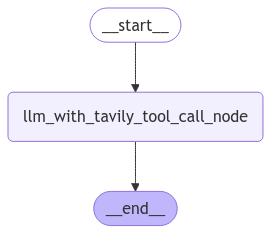

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
basic_messages_response = graph.invoke({"messages": HumanMessage(content="Hello!", name="Kokko")})
for m in basic_messages_response['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Kokko

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


In [18]:
gundam_messages = graph.invoke({"messages": gundam_messages})
for m in gundam_messages_response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching life-sized Gundams?
================================ Human Message =================================
Name: Kokko

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Kokko

I want to learn about the best place to see life-sized Gundams in Japan
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (78b9cc29-d718-457e-be0f-f2d788ec173b)
 Call ID: 78b9cc29-d718-457e-be0f-f2d788ec173b
  Args:
    query: best place to see life-sized Gundams in Japan
